In [1]:
# First, I import some helpful packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Also, I set some font formatting for latex text
#plt.rc("text", usetex=True)
#plt.rc("font", **{"family":"serif", "size":11})

new_rc_params = {"text.usetex": False,
                 "svg.fonttype": 'none',
                 "savefig.dpi": 300,
                 "font.size": 12,
                 "legend.fontsize": 12,
                 #"figure.titlesize": 12,
                 "lines.linewidth": 1.0,
                }

mpl.rcParams.update(new_rc_params)


In [2]:
# Here, I define a few helper functions that convert spike counts to probabilities and vice verca
def count_to_prob(c, steps):
    # deterministic transformation from number of spikes to probability of activity
    return c / steps

def prob_to_count(p, steps):
    # deterministic transformation from probability of activity to number of spikes
    return np.round_(p*steps).astype(int)


In [3]:
# Here, I define three different functions to generate spike trains from summarized statistics
def poisson_encode(p, steps):
    # generate spike train from firing rate / spike density via Poisson encoding
    spikes = []
    for t in np.arange(1, steps + 1):
        if p > np.random.rand():
            spikes.append(t)
    return spikes

def uniform_encode(f, steps):
    # generate spike train from fixed spike number via uniform distribution across time
    return np.random.choice(np.arange(1, steps + 1), f, replace=False)

def linear_encode(f, steps):
    # generate spike train from fixed spike number via linear distribution
    return np.round_(np.linspace(1, steps, f))

In [146]:
# Now, lets define how arbitrary incoming spike trains are integrated over time
# based on deterministic spiking neuron internal dynamics  
def integrate_spike_trains(steps, spikes_in, weights_in, threshold, tau, u_rest, u0):
    # integrates a number of incoming spike trains as list-like objects of spike timepoints

    assert len(spikes_in) == len(weights_in)

    x = np.arange(0, steps + 1)

    v = u0
    v_t = []
    spikes_out = []
    for t in x:
        v = v * tau
        for i in range(len(spikes_in)):
            if t in spikes_in[i]:
                v += weights_in[i]
        v_t.append(v)
        if v >= threshold:
            v = u_rest
            spikes_out.append(t)
        if v < -threshold:
            v = -threshold
           
    V_t = [0.0]
    for v in v_t[1:]:
        V_t.append(tau*V_t[-1]+v)
            
    return v_t, V_t, spikes_out

In [155]:
# Now I give a function to display the integration process visually
def plot_spike_integration(steps, spikes_in, weights_in, u_t, U_t, spikes_out, u_rest, threshold,
                           title="", show=True, close=True, file="", fig=None, label=""):

    x = np.arange(0, steps + 1)

    if fig==None:
        fig, axs = plt.subplots(3, 1, figsize=(5,6), sharex=True, gridspec_kw={'height_ratios': [5, 5, 10]})
        plt.subplots_adjust(wspace=0, hspace=0)
        fig.patch.set_facecolor('xkcd:white')
        fig.suptitle(title + r" $\Sigma_t \phi_{out} = $" + f" {len(spikes_out)}", fontsize=12)

        axs[0].hlines(u_rest, min(x), max(x), colors="black", linestyles="--", label="$u_{rest}$", lw=1, alpha=0.5)
        axs[0].hlines(threshold, min(x), max(x), colors="red", linestyles="--", label="threshold", lw=1, alpha=0.5)
        axs[0].set_yticks([u_rest, threshold])
        axs[0].set_yticklabels([r"$u_{rest}$", r"$\omega$"])
    else:
        axs = fig.axes

    axs[0].plot(x,u_t, label="$u(t)$" + label)
    axs[1].plot(x,U_t, label="$U(t)$" + label)

    sign_colors = ["g" if w > 0.0 else "r" for w in weights_in] + ["b"]
    axs[2].eventplot(spikes_in + [spikes_out], colors=sign_colors, linelengths=0.8)

    #axs[0].legend()
    
    #axs[0].set_ylabel("membrane potential $u$")

    axs[2].set_xlabel("$t$")
    axs[2].set_yticks(np.arange(0, len(spikes_in)+1))
    #ylabels = [r"$\phi^{+}$" if w > 0.0 else r"$\phi^{-}$" for w in weights_in] + [r"$\phi_{out}$"]
    ylabels = ["" for w in weights_in] + [r"$\phi_{out}$"]
    axs[2].set_yticklabels(ylabels)
    axs[0].xaxis.set_tick_params(length=0)
    axs[1].xaxis.set_tick_params(length=0)
    
    axs[0].spines["top"].set_visible(False)
    axs[0].spines["right"].set_visible(False)
    axs[0].spines["bottom"].set_visible(False)
    axs[1].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)
    axs[1].spines["bottom"].set_visible(False)
    axs[2].spines["top"].set_visible(False)
    axs[2].spines["right"].set_visible(False)
    axs[2].spines["left"].set_visible(False)
    
    plt.tight_layout()
    if file:
        plt.savefig(file, dpi=300)
    if show:
        plt.show()
    if close:
        plt.close()
    return fig

In [180]:
def plot_multicell_spike_integration(steps, spikes_in, weights_ins, u_ts, U_ts, spikes_outs, u_rest, threshold,
                           title="", show=True, close=True, file="", labels=None):

    x = np.arange(0, steps + 1)

    fig, axs = plt.subplots(3, 1, figsize=(4,6), sharex=True, gridspec_kw={'height_ratios': [5, 5, 10]})
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.patch.set_facecolor('xkcd:white')
    fig.suptitle(title, fontsize=12)

    axs[0].hlines(u_rest, min(x), max(x), colors="black", linestyles="--", label="$u_{rest}$", lw=1, alpha=0.5)
    axs[0].hlines(threshold, min(x), max(x), colors="red", linestyles="--", label="threshold", lw=1, alpha=0.5)
    axs[0].set_yticks([u_rest, threshold])
    axs[0].set_yticklabels([r"$u_{rest}$", r"$\omega$"])

    for i in range(len(u_ts)):
        if labels:
            label = labels[i]
        else:
            label = f"neuron {i+1}"
        axs[0].plot(x,u_ts[i], label="$u(t)$" + label)
        axs[1].plot(x,U_ts[i], label="$U(t)$" + label)

    sign_colors = ["g" for w in weights_ins[0]] + ["b"] * len(u_ts)
    axs[2].eventplot(spikes_in + spikes_outs, colors=sign_colors, linelengths=0.8)

    #axs[0].legend()
    
    #axs[0].set_ylabel("membrane potential $u$")

    axs[2].set_xlabel("$t$")
    axs[2].set_yticks(np.arange(0, len(spikes_in)+1))
    #ylabels = [r"$\phi^{+}$" if w > 0.0 else r"$\phi^{-}$" for w in weights_in] + [r"$\phi_{out}$"]
    ylabels = ["" for w in weights_ins[0]] + [(r" $\Sigma_t \phi_{out} = $" + f" {len(spikes_outs[i])}") for i in range(len(u_ts))]
    print(ylabels)
    axs[2].set_yticklabels(ylabels)
    axs[0].xaxis.set_tick_params(length=0)
    axs[1].xaxis.set_tick_params(length=0)
    
    axs[0].spines["top"].set_visible(False)
    axs[0].spines["right"].set_visible(False)
    axs[0].spines["bottom"].set_visible(False)
    axs[1].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)
    axs[1].spines["bottom"].set_visible(False)
    axs[2].spines["top"].set_visible(False)
    axs[2].spines["right"].set_visible(False)
    axs[2].spines["left"].set_visible(False)
    
    plt.tight_layout()
    if file:
        plt.savefig(file, dpi=300)
    if show:
        plt.show()
    if close:
        plt.close()
    return fig

In [6]:
# A function that chooses which of the above defined functions to use based on parameter choices
def run_simulation():

    for i in np.arange(repeats):

        np.random.seed(i)

        if encoding=="poisson":
            spikes_in = [poisson_encode(p, steps) for p in probs]

        elif encoding=="uniform":
            frequencies = [prob_to_count(p, steps) for p in probs]
            spikes_in = [uniform_encode(f, steps) for f in frequencies]

        elif encoding=="linear":
            frequencies = [prob_to_count(p, steps) for p in probs]
            spikes_in = [linear_encode(f, steps) for f in frequencies]
            
        u_t, U_t, spikes_out = integrate_spike_trains(steps,
                                                 spikes_in,
                                                 weights_in,
                                                 threshold,
                                                 tau,
                                                 u_rest,
                                                 u0
                                                 )

        title = f"{encoding} encoding,"
        plot_spike_integration(steps,
                               spikes_in,
                               weights_in,
                               u_t,
                               spikes_out,
                               u_rest,
                               threshold,
                               title=title,
                               )


In [176]:
# Also, we need to define a bunch of parameter values of the simulation

repeats = 5         # how often to run the simulation
steps = 100         # number of time steps simulated

u_rest = 0.0        # resting membrane potential
u0 = u_rest         # initial membrane potential
threshold = 1.0     # firing threshold
tau = 0.99          # decay term of membrane potential

# Weights of the incoming neurons
w1 = 0.8            
w2 = -0.8
w3 = -0.8
weights_in = [w1, w2] #, w3]

# Firing probabilities of incoming neurons at each time step
p1 = 0.05
p2 = 0.03
p3 = 0.07
probs = [p1, p2] #, p3]

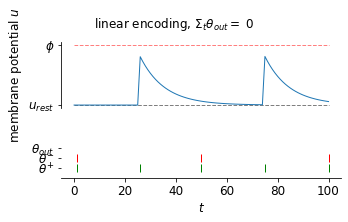

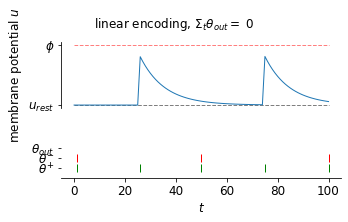

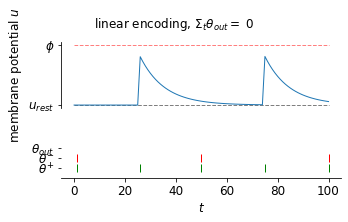

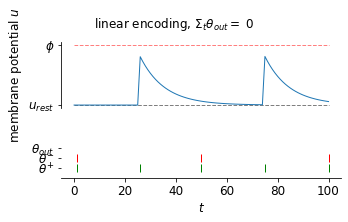

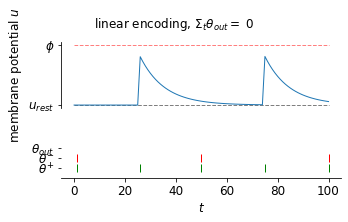

In [8]:
# Finally, lets compare the different spike train generation methods used in simulation
# "linear" encoding is fully deterministic
# and spreads the expected number of spikes in equally spaced intervals
encoding = "linear"
run_simulation()

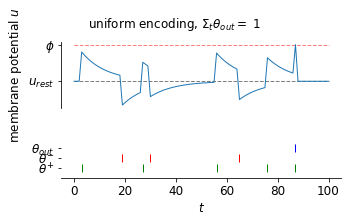

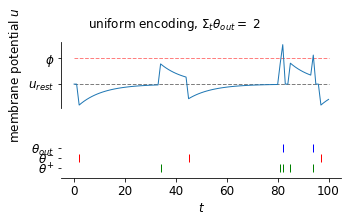

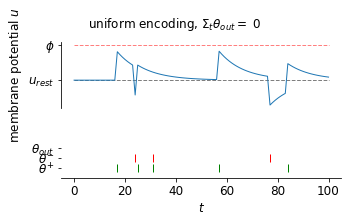

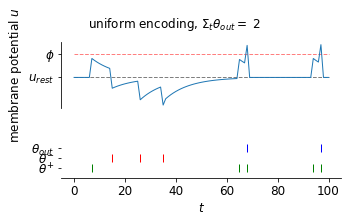

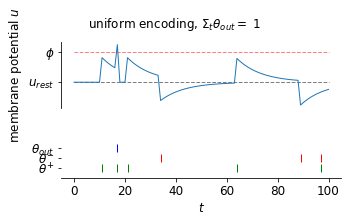

In [9]:
# "uniform" encoding is deterministic about the number of spikes, but their spacing is uniform random
encoding = "uniform"
run_simulation()

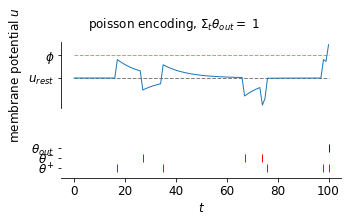

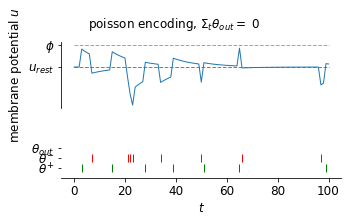

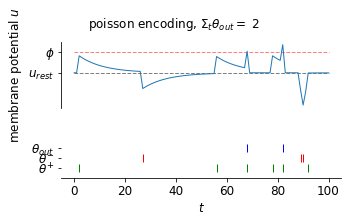

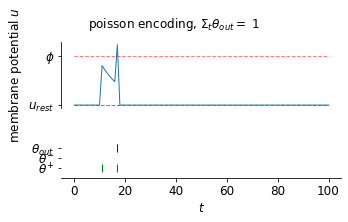

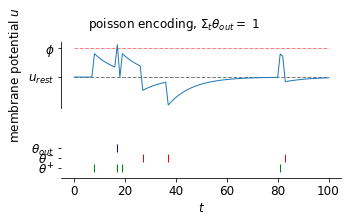

In [10]:
# "poisson" encoding uses a random process to determine the number of spikes and their timing
encoding = "poisson"
run_simulation()

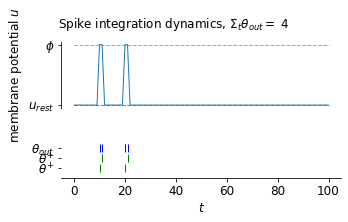

In [11]:
steps = 100
spikes_in = [
    [10, 20],
    [11, 21],
    
            ]
weights_in = [1.0, 1.0]

u_t, U_t, spikes_out = integrate_spike_trains(steps,
                                         spikes_in,
                                         weights_in,
                                         threshold,
                                         tau,
                                         u_rest,
                                         u0
                                         )

title = f"Spike integration dynamics,"
plot_spike_integration(steps,
                       spikes_in,
                       weights_in,
                       u_t,
                       spikes_out,
                       u_rest,
                       threshold,
                       title=title,
                       file="integration_demo.svg"
                       )

15.7
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ' $\\Sigma_t \\phi_{out} = $ 0', ' $\\Sigma_t \\phi_{out} = $ 22', ' $\\Sigma_t \\phi_{out} = $ 98']


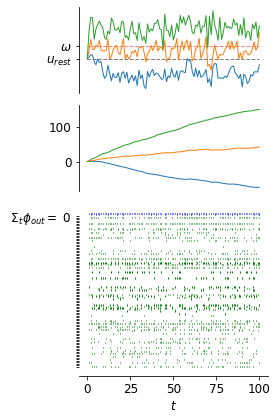

17.46
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ' $\\Sigma_t \\phi_{out} = $ 0', ' $\\Sigma_t \\phi_{out} = $ 4', ' $\\Sigma_t \\phi_{out} = $ 99']


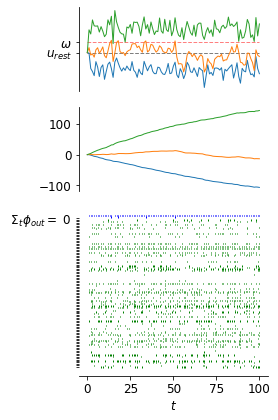

16.38
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ' $\\Sigma_t \\phi_{out} = $ 0', ' $\\Sigma_t \\phi_{out} = $ 0', ' $\\Sigma_t \\phi_{out} = $ 93']


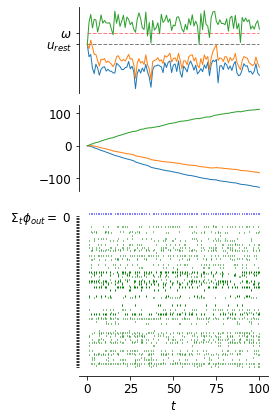

13.64
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ' $\\Sigma_t \\phi_{out} = $ 0', ' $\\Sigma_t \\phi_{out} = $ 8', ' $\\Sigma_t \\phi_{out} = $ 96']


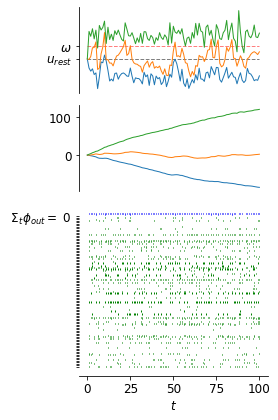

15.24
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ' $\\Sigma_t \\phi_{out} = $ 0', ' $\\Sigma_t \\phi_{out} = $ 26', ' $\\Sigma_t \\phi_{out} = $ 100']


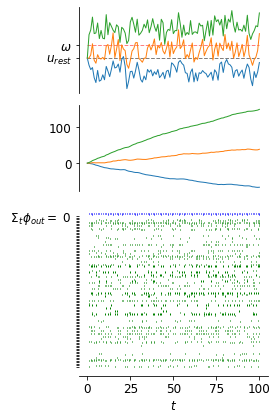

In [186]:
np.random.seed(3)
fan_in = 100
freq_in = 20
steps = 100
p = 0.1

weights_in = np.random.normal(scale=np.sqrt(2/fan_in) , size=fan_in)
weights_in = np.sort(weights_in)

for s in range(5):

    #spikes_in = np.random.randint(1, 101, (fan_in, freq_in))
    #spikes_in = np.sort(spikes_in)
    #spikes_in = [l.tolist() for l in spikes_in]
    
    spikes_in = [poisson_encode(np.random.normal(p, 0.25), steps) for _ in range(fan_in)]
    print(np.mean([len(x) for x in spikes_in]))
    
    weights_ins = []
    u_ts = []
    U_ts = []
    spikes_outs = []

    for d, i in enumerate([-0.02, 0.02, 0.15]):

        weights_ins.append(weights_in + i)
        u_t, U_t, spikes_out = integrate_spike_trains(steps,
                                                 spikes_in,
                                                 weights_in + i,
                                                 threshold,
                                                 tau,
                                                 u_rest,
                                                 u0
                                                 )
        u_ts.append(u_t)
        U_ts.append(U_t)
        spikes_outs.append(spikes_out)
        
        title = r"$\mu(\theta)=$" + f"{np.mean(weights_in + i):.3f},   "
        """
        fig = plot_spike_integration(steps,
                               spikes_in,
                               weights_in + i,
                               u_t,
                               U_t,
                               spikes_out,
                               u_rest,
                               threshold,
                               title=title,
                               file=f"integration_demo_n{i}_e{s}.svg",
                               close=False,
                               show=False,
                               fig=fig,
                               )
        """
    plot_multicell_spike_integration(
        steps, 
        spikes_in, 
        weights_ins,
        u_ts, 
        U_ts, 
        spikes_outs, 
        u_rest, 
        threshold,
        title="", 
        show=True, 
        close=True, 
        file=f"integration_demo_e{s}.svg", 
        labels=None)

        

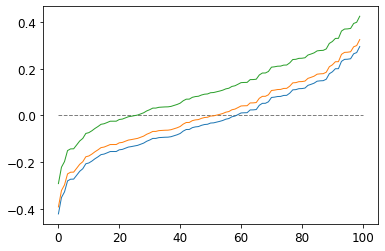

In [136]:
for d, i in enumerate([-0.01, 0.02, 0.12]):
    plt.plot(weights_in + i)
plt.hlines(0, xmin=0, xmax=100, linestyles="--", lw=1, alpha=0.5)
plt.savefig("weights.svg")